In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime

from utils.load_data import load_data, load_gt_data
from utils.preprocessing import Preprocessing
from utils.results import compute_rsquared
from models.MLP import MLP
from models.LinearModels import OLS, RidgeRegression
from models.KalmanFilterMLP import KalmanFilterMLP
import statsmodels.api as sm
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

%reload_ext autoreload
%autoreload 2

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [17]:
TEST_ALL_GT_DATA = False # If set to True, the model will be trained on all available data and predictions will be made for all available GT data

TRAIN_PROPORTION = 0.9 if not TEST_ALL_GT_DATA else 1
PAST_GDPS = [] if not TEST_ALL_GT_DATA else None # e.g. range(1, 3) or [1, 2]
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [18]:
data, all_gdps, all_gts = load_data()
search_terms = [col for col in all_gts.columns if col.endswith('_average')]

In [19]:
processed_gts = all_gts.copy() # Monthly Google Trends
processed_gts['date'] = pd.to_datetime(processed_gts['date'])
processed_gts[search_terms] = np.log(processed_gts[search_terms] + 1)

for nb_years in range(1, 3): # 3 will add 2 years difference
    diff = (processed_gts[search_terms] - processed_gts.groupby("country")[search_terms].diff(nb_years * 12)).add_suffix(f'_{nb_years}y_diff')
    processed_gts = pd.concat([processed_gts, diff], axis=1)

processed_gts.drop(columns=search_terms, inplace=True)


In [20]:
print(f"Data shape: {data.shape}")

data['date'] = pd.to_datetime(data['date'])
processed_gts = processed_gts.dropna()
data_merged = data.merge(processed_gts, left_on=["country", "date"], right_on=["country", "date"], how="left")
data_merged['date'] = pd.to_datetime(data_merged['date']).dt.strftime('%Y-%m-%d')

print(f"Data merged shape: {data_merged.shape}")

Data shape: (550, 97)
Data merged shape: (550, 285)


In [21]:
data_dt = data_merged.copy()
data_dt['date'] = pd.to_datetime(data_dt['date'])
splitting_date = data_dt['date'].quantile(TRAIN_PROPORTION)


In [22]:
preprocessor = Preprocessing(data=data_merged, epsilon=EPS, mode=MODE, past_GDP_lags=PAST_GDPS, diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)
X_train, y_train, X_valid, y_valid = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, shuffle=False, splitting_date=splitting_date)

X_train[preprocessor.country_train == "Switzerland"].head()



X_train shape : (438, 292)
X_valid shape : (60, 292)
y_train shape : (438,)
y_valid shape : (60,)


,Expense_average,Research_and_development_average,Capital_expenditure_average,Business_average,Cost_average,Tax_average,Financial_capital_average,Investment_average,Gross_domestic_product_average,Credit_average,...,country_Germany,country_Japan,country_Korea,country_Switzerland,country_United Kingdom,country_United States,month_3,month_6,month_9,month_12
4,0.035926,-1.589690,-1.889848,1.205852,-1.331198,0.707219,-0.610806,1.417080,-1.077500,0.811169,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,1.0,0.0,0.0,0.0
10,-0.017415,-1.519000,-1.889848,1.105522,-1.514042,-1.083470,-0.610806,0.652095,-1.343835,1.034876,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,0.0,1.0,0.0,0.0
16,0.462658,-1.306930,-1.889848,1.138965,-1.392146,-0.864760,-0.610806,0.860727,-0.988722,0.721686,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,0.0,0.0,1.0,0.0
20,-1.297609,-1.589690,-1.889848,1.038635,-1.574990,-1.138147,-0.610806,0.721639,-1.432613,1.079618,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,0.0,0.0,0.0,1.0
28,-0.017415,-1.236239,-1.889848,1.306181,-1.453094,0.898590,-0.610806,1.208448,-1.343835,1.392808,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,1.0,0.0,0.0,0.0


In [23]:
# Print all columns that contain Research_and_development
search_term = "Research_and_development"
search_cols = [col for col in X_train.columns if search_term in col]
other_cols = []
X_train[preprocessor.country_train == "Switzerland"][search_cols + other_cols].head()

,Research_and_development_average,Research_and_development_average_1y_diff,Research_and_development_average_2y_diff
4,-1.589690,-0.291910,-6.392120
10,-1.519000,-7.792997,-6.392120
16,-1.306930,-7.792997,-6.392120
20,-1.589690,-0.722410,-0.118996
28,-1.236239,-1.714881,-0.271314


Explained variance ratio: 0.984660722709855


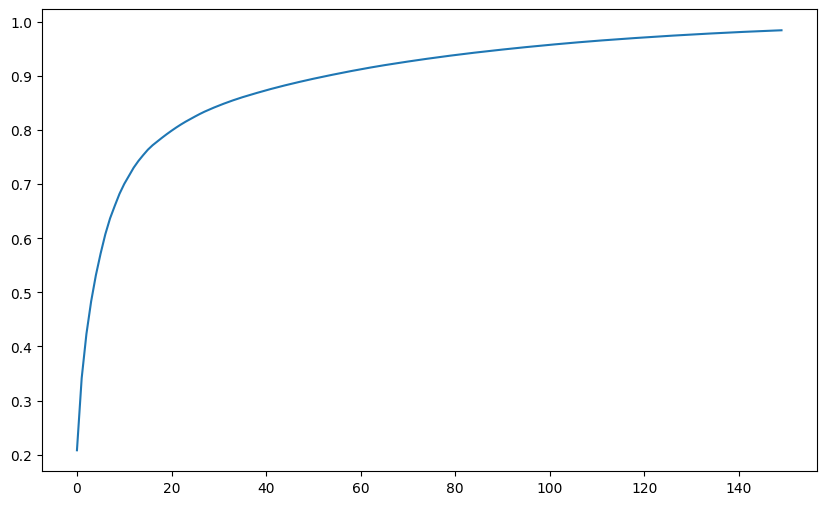

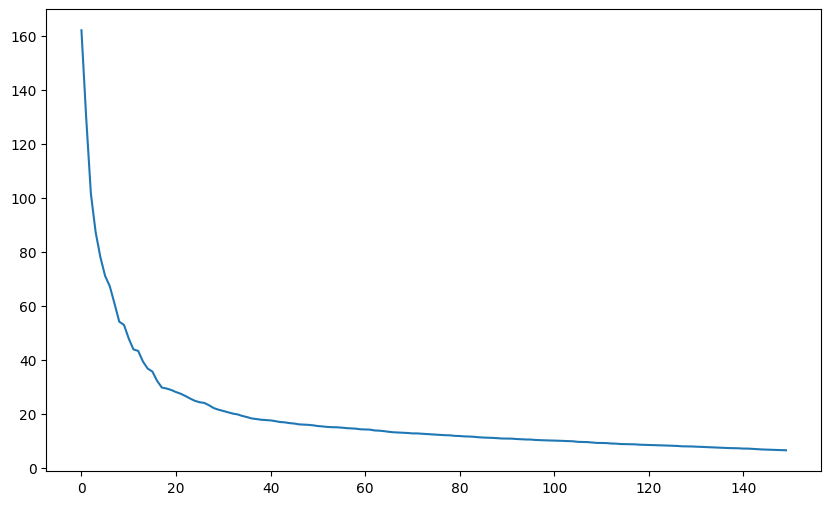

In [24]:
# Apply PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plot

pca = PCA(150)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)

print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum()}")
plot.figure(figsize=(10, 6))
plot.plot(np.cumsum(pca.explained_variance_ratio_))

# Plot singular values
plot.figure(figsize=(10, 6))
plot.plot(pca.singular_values_)
plot.show()

In [25]:
# x_train = X_train.values
# x_valid = X_valid.values
x_train = X_train_pca
x_valid = X_valid_pca
y_train = y_train.values
y_valid = y_valid.values
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid

## Simple Prediction Model

### We start with a simple regression model

In [26]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [27]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
# Function to set random seed
def set_seed(seed):
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
    torch.cuda.manual_seed_all(seed)  # PyTorch for all GPUs (if multiple GPUs are used)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Avoids non-deterministic optimizations
    
def train_nn(x_train, y_train, x_valid, y_valid, num_epochs=2000, learning_rate=1e-3, weight_decay=1e-3, verbose = True):
    num_features = x_train.shape[1]
    model = NeuralNetwork(num_features=num_features).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    
    x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)

    training_loss = []
    validation_loss = []
    valid_r_squared = []
    
    epoch_range = tqdm(range(num_epochs)) if verbose else range(num_epochs)
    for t in epoch_range:
        model.train()
        y_pred = model(x_train_t)
        loss_train = loss_fn(y_pred, y_train_t)

        model.eval()
        loss_valid = loss_fn(model(x_valid_t), y_valid_t)
        model.train()

        r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())

        valid_r_squared.append(r_squared)
        training_loss.append(loss_train.item())
        validation_loss.append(loss_valid.item())

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    model.eval()
    y_pred = model(x_valid_t)

    v_loss = loss_fn(y_pred, y_valid_t)
    validation_loss.append(v_loss.item())
    print(f"Validation loss: {v_loss.item()}")

    t_loss = loss_fn(model(x_train_t), y_train_t)
    training_loss.append(t_loss.item())
    print(f"Training loss: {t_loss.item()}")

    r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
    valid_r_squared.append(r_squared)
    print(f"Validation R^2: {r_squared}")
    
    return model, training_loss, validation_loss, valid_r_squared

In [28]:
model, training_loss, validation_loss, validation_r_squared = train_nn(x_train, y_train, x_valid, y_valid, num_epochs=300, learning_rate=1e-3, weight_decay=5e-2)

  0%|          | 0/300 [00:00<?, ?it/s]

Validation loss: 0.8981422185897827
Training loss: 0.01779307797551155
Validation R^2: 0.0983272562715164


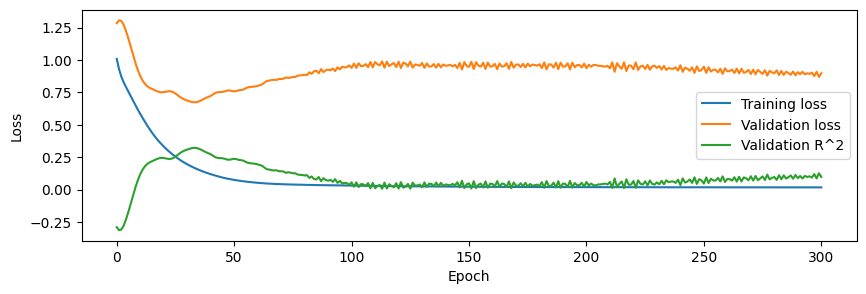

In [29]:
plt.figure(figsize=(10, 3))
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.plot(validation_r_squared, label="Validation R^2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime

from utils.load_data import load_data, load_gt_data
from utils.preprocessing import Preprocessing
from utils.results import compute_rsquared
from models.MLP import MLP
from models.LinearModels import OLS, RidgeRegression
from models.KalmanFilterMLP import KalmanFilterMLP
import statsmodels.api as sm
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

%reload_ext autoreload
%autoreload 2

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [31]:
TEST_ALL_GT_DATA = False # If set to True, the model will be trained on all available data and predictions will be made for all available GT data

TRAIN_PROPORTION = 0.9 if not TEST_ALL_GT_DATA else 1
PAST_GDPS = [] if not TEST_ALL_GT_DATA else None # e.g. range(1, 3) or [1, 2]
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [32]:
data, all_gdps, all_gts = load_data()

In [33]:
search_terms = [col for col in all_gts.columns if col.endswith('_average')]

processed_gts = all_gts.copy() # Monthly Google Trends
processed_gts['date'] = pd.to_datetime(processed_gts['date'])
processed_gts[search_terms] = np.log(processed_gts[search_terms] + 1)

# for nb_quarters in range(1, 3 * 3):
#     diff = (processed_gts[search_terms] - processed_gts.groupby("country")[search_terms].diff(nb_quarters * 3)).add_suffix(f'_{nb_quarters}q_diff')
#     processed_gts = pd.concat([processed_gts, diff], axis=1)

for nb_years in range(1, 3): # 3 will add 2 years difference
    diff = (processed_gts[search_terms] - processed_gts.groupby("country")[search_terms].diff(nb_years * 12)).add_suffix(f'_{nb_years}y_diff')
    processed_gts = pd.concat([processed_gts, diff], axis=1)

processed_gts.drop(columns=search_terms, inplace=True)


In [34]:
print(f"Data shape: {data.shape}")

data['date'] = pd.to_datetime(data['date'])
processed_gts = processed_gts.dropna()
data_merged = data.merge(processed_gts, left_on=["country", "date"], right_on=["country", "date"], how="left")
data_merged['date'] = pd.to_datetime(data_merged['date']).dt.strftime('%Y-%m-%d')

print(f"Data merged shape: {data_merged.shape}")

Data shape: (550, 97)
Data merged shape: (550, 285)


In [35]:
data_dt = data_merged.copy()
data_dt['date'] = pd.to_datetime(data_dt['date'])
splitting_date = data_dt['date'].quantile(TRAIN_PROPORTION)


In [36]:
preprocessor = Preprocessing(data=data_merged, epsilon=EPS, mode=MODE, past_GDP_lags=PAST_GDPS, diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)
X_train, y_train, X_valid, y_valid = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, shuffle=False, splitting_date=splitting_date)

X_train[preprocessor.country_train == "Switzerland"].head()



X_train shape : (438, 292)
X_valid shape : (60, 292)
y_train shape : (438,)
y_valid shape : (60,)


,Expense_average,Research_and_development_average,Capital_expenditure_average,Business_average,Cost_average,Tax_average,Financial_capital_average,Investment_average,Gross_domestic_product_average,Credit_average,...,country_Germany,country_Japan,country_Korea,country_Switzerland,country_United Kingdom,country_United States,month_3,month_6,month_9,month_12
4,0.035926,-1.589690,-1.889848,1.205852,-1.331198,0.707219,-0.610806,1.417080,-1.077500,0.811169,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,1.0,0.0,0.0,0.0
10,-0.017415,-1.519000,-1.889848,1.105522,-1.514042,-1.083470,-0.610806,0.652095,-1.343835,1.034876,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,0.0,1.0,0.0,0.0
16,0.462658,-1.306930,-1.889848,1.138965,-1.392146,-0.864760,-0.610806,0.860727,-0.988722,0.721686,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,0.0,0.0,1.0,0.0
20,-1.297609,-1.589690,-1.889848,1.038635,-1.574990,-1.138147,-0.610806,0.721639,-1.432613,1.079618,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,0.0,0.0,0.0,1.0
28,-0.017415,-1.236239,-1.889848,1.306181,-1.453094,0.898590,-0.610806,1.208448,-1.343835,1.392808,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,1.0,0.0,0.0,0.0


In [37]:
# Print all columns that contain Research_and_development
# search_term = "Research_and_development"
# search_cols = [col for col in X_train.columns if search_term in col]
# other_cols = []
# X_train[preprocessor.country_train == "Switzerland"][search_cols + other_cols].head()

Explained variance ratio: 0.984660722709855


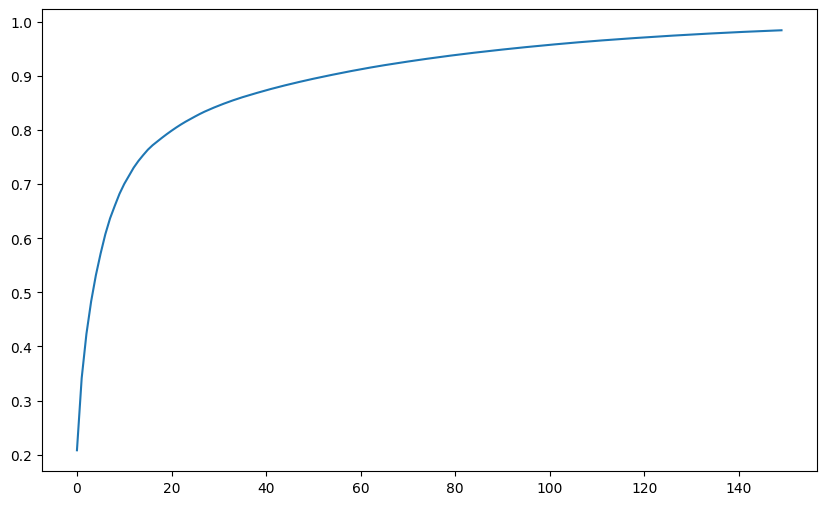

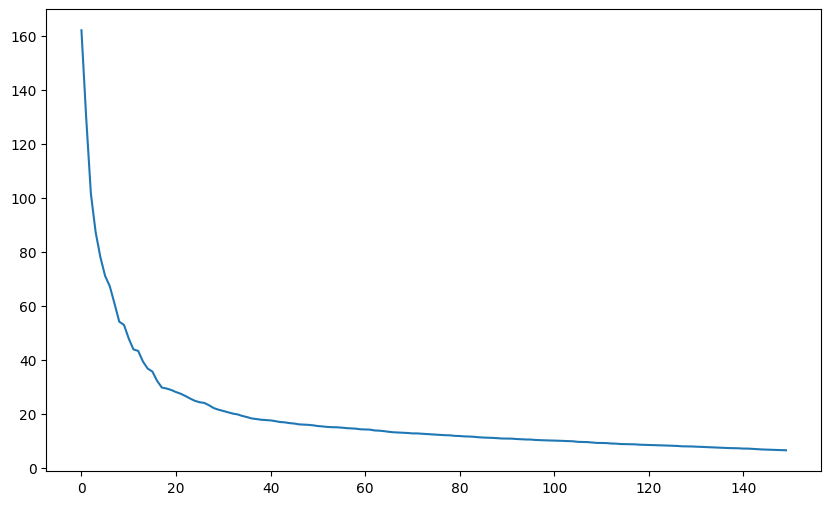

In [38]:
# Apply PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plot

pca = PCA(150)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)

print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum()}")
plot.figure(figsize=(10, 6))
plot.plot(np.cumsum(pca.explained_variance_ratio_))

# Plot singular values
plot.figure(figsize=(10, 6))
plot.plot(pca.singular_values_)
plot.show()

In [39]:
# x_train = X_train.values
# x_valid = X_valid.values

def add_noise(x_train, y_train, preprocessor):
    # Add gaussian noise to x_train and associat clean y_train to it
    x_train_noisy = x_train + np.random.normal(0, 0.01, x_train.shape)

    # Add other type of noise
    x_train_noisy_2 = x_train + np.random.normal(0, 0.005, x_train.shape)

    print(x_train.shape, x_train_noisy.shape, x_train_noisy_2.shape)

    # Concatenate the noisy data to the clean data
    x_train = np.concatenate((x_train, x_train_noisy, x_train_noisy_2), axis=0)
    y_train = np.concatenate((y_train, y_train, y_train), axis=0)

    # Shuffle the data
    idx = np.random.permutation(len(x_train))
    x_train = x_train[idx]
    y_train = y_train[idx]

    country_train = np.concatenate((preprocessor.country_train, preprocessor.country_train, preprocessor.country_train))[idx]
    dates_train = np.concatenate((preprocessor.dates_train, preprocessor.dates_train + pd.DateOffset(1), preprocessor.dates_train + pd.DateOffset(2)))[idx]

    return x_train, y_train, country_train, country_train, dates_train


x_train, y_train, country_train, country_train, dates_train = add_noise(X_train_pca, y_train.values, preprocessor)
x_valid = X_valid_pca
y_valid = y_valid.values

preprocessor.country_train = country_train
preprocessor.dates_train = dates_train

(438, 150) (438, 150) (438, 150)


## Simple Prediction Model

### We start with a simple regression model

In [40]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [41]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
# Function to set random seed
def set_seed(seed):
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
    torch.cuda.manual_seed_all(seed)  # PyTorch for all GPUs (if multiple GPUs are used)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Avoids non-deterministic optimizations
    
def train_nn(x_train, y_train, x_valid, y_valid, num_epochs=2000, learning_rate=1e-3, weight_decay=1e-3, verbose = True):
    num_features = x_train.shape[1]
    model = NeuralNetwork(num_features=num_features).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    
    x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)

    training_loss = []
    validation_loss = []
    valid_r_squared = []
    
    epoch_range = tqdm(range(num_epochs)) if verbose else range(num_epochs)
    for t in epoch_range:
        model.train()
        y_pred = model(x_train_t)
        loss_train = loss_fn(y_pred, y_train_t)

        model.eval()
        loss_valid = loss_fn(model(x_valid_t), y_valid_t)
        model.train()

        r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())

        valid_r_squared.append(r_squared)
        training_loss.append(loss_train.item())
        validation_loss.append(loss_valid.item())

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    model.eval()
    y_pred = model(x_valid_t)

    v_loss = loss_fn(y_pred, y_valid_t)
    validation_loss.append(v_loss.item())
    print(f"Validation loss: {v_loss.item()}")

    t_loss = loss_fn(model(x_train_t), y_train_t)
    training_loss.append(t_loss.item())
    print(f"Training loss: {t_loss.item()}")

    r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
    valid_r_squared.append(r_squared)
    print(f"Validation R^2: {r_squared}")
    
    return model, training_loss, validation_loss, valid_r_squared

In [42]:
model, training_loss, validation_loss, validation_r_squared = train_nn(x_train, y_train, x_valid, y_valid, num_epochs=5000, learning_rate=1e-3, weight_decay=5e-2)

  0%|          | 0/5000 [00:00<?, ?it/s]

Validation loss: 0.8515691757202148
Training loss: 0.015973549336194992
Validation R^2: 0.14508337756737488


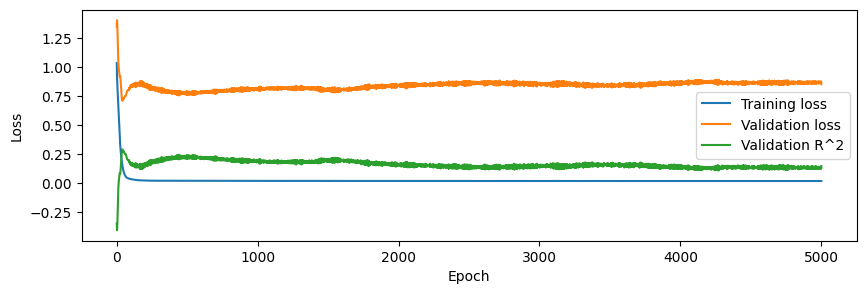

In [43]:
plt.figure(figsize=(10, 3))
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.plot(validation_r_squared, label="Validation R^2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [44]:
# Make bootrapping
n_bootstrap = 250
n = len(x_train)
n_features = x_train.shape[1]

n_countries = len(np.unique(country_train))

bootstrap_size = n // n_countries # np.ceil(150 / n_countries).astype(int)

bootstrap_models = []
mse_bootstrap = np.zeros(n_bootstrap)
rsquared_bootstrap = np.zeros(n_bootstrap)

for i in tqdm(range(n_bootstrap)):
    # Make a bootstrap sample of size bootstrap_size
    set_seed(SEED + i)

    indices_per_country = [np.where(country_train == c)[0] for c in np.unique(country_train)]
    bootstrap_idx = np.concatenate([np.random.choice(indices, size=bootstrap_size, replace=True) for indices in indices_per_country])
    x_train_bootstrap = x_train[bootstrap_idx]
    y_train_bootstrap = y_train[bootstrap_idx]

    model_bootstrap, _, _, _ = train_nn(x_train_bootstrap, y_train_bootstrap, x_valid, y_valid, num_epochs=50, learning_rate=1e-3, weight_decay=5e-2, verbose=False)
    y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

    mse = mean_squared_error(y_valid, y_pred)
    rsquared = compute_rsquared(y_valid, y_pred)

    bootstrap_models.append(model_bootstrap)
    mse_bootstrap[i] = mse
    rsquared_bootstrap[i] = rsquared

# Aggregate the predictions
y_pred = np.zeros((x_valid.shape[0], n_bootstrap))
for i in range(n_bootstrap):
    y_pred[:, i] = bootstrap_models[i](torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

y_pred_mean = np.mean(y_pred, axis=1)
y_pred_std = np.std(y_pred, axis=1)
y_pred_median = np.median(y_pred, axis=1)

# Get the model with the best R squared
best_model_idx = np.argmax(rsquared_bootstrap)
best_model = bootstrap_models[best_model_idx]
best_rsquared = rsquared_bootstrap[best_model_idx]
y_pred_best = best_model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

  0%|          | 0/250 [00:00<?, ?it/s]

Validation loss: 0.6470142602920532
Training loss: 0.0767890214920044
Validation R^2: 0.3504423952496065
Validation loss: 0.8068618774414062
Training loss: 0.07845519483089447
Validation R^2: 0.18996640412998245
Validation loss: 0.8787034749984741
Training loss: 0.08959159255027771
Validation R^2: 0.11784233464311011
Validation loss: 0.7264197468757629
Training loss: 0.07445834577083588
Validation R^2: 0.2707247824293392
Validation loss: 0.822162389755249
Training loss: 0.0736418217420578
Validation R^2: 0.1746057004004571
Validation loss: 0.7461673021316528
Training loss: 0.08409597724676132
Validation R^2: 0.2508995231014478
Validation loss: 0.6481376886367798
Training loss: 0.07856962084770203
Validation R^2: 0.34931454736978473
Validation loss: 0.6415539383888245
Training loss: 0.07293687760829926
Validation R^2: 0.35592413059586225
Validation loss: 0.695673942565918
Training loss: 0.06102854758501053
Validation R^2: 0.3015913727767977
Validation loss: 0.6237636804580688
Training l

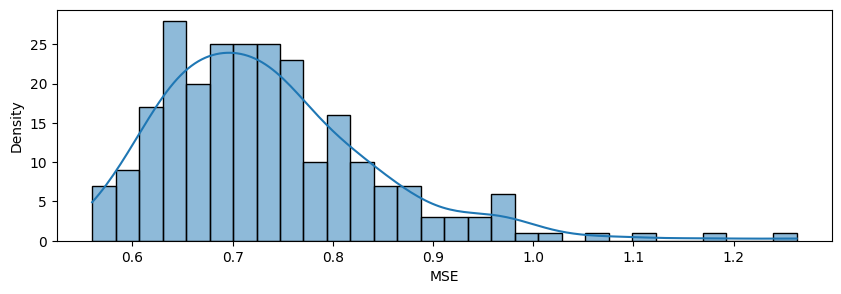

In [45]:
# Plot the MSE
plt.figure(figsize=(10, 3))
sns.histplot(mse_bootstrap, bins=30, kde=True)
plt.xlabel("MSE")
plt.ylabel("Density")
plt.show()

Bootstrapped R^2: 0.34589835117319734


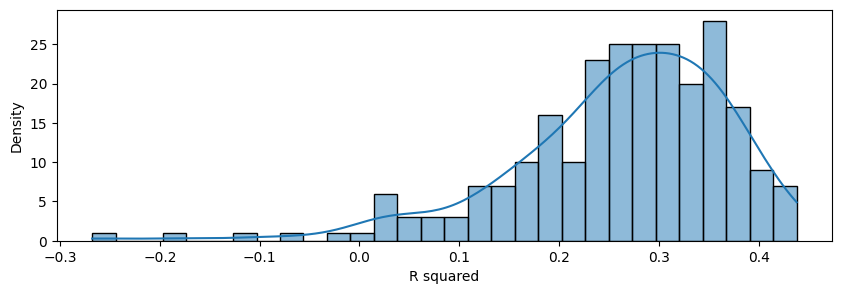

In [46]:
# Plot the r squared
bootstrapped_r2 = compute_rsquared(y_valid, y_pred_mean)
print(f"Bootstrapped R^2: {bootstrapped_r2}")

plt.figure(figsize=(10, 3))
sns.histplot(rsquared_bootstrap, bins=30, kde=True)
plt.xlabel("R squared")
plt.ylabel("Density")
plt.show()

In [47]:
# Plot the predictions per country, per date
def plot_by_country(selected_country, country_valid):
    plt.figure(figsize=(15, 5))
    plt.plot(y_valid[country_valid == selected_country], label="True")
    plt.plot(y_pred_mean[country_valid == selected_country], label="Predicted")
    plt.plot(y_pred_median[country_valid == selected_country], label="Predicted (median)")
    plt.plot(y_pred_best[country_valid == selected_country], label="Predicted (best)")
    plt.fill_between(np.arange(len(y_valid[country_valid == selected_country])), y_pred_mean[country_valid == selected_country] - 3 * y_pred_std[country_valid == selected_country], y_pred_mean[country_valid == selected_country] + 3 * y_pred_std[country_valid == selected_country], alpha=0.05, color="red")
    plt.fill_between(np.arange(len(y_valid[country_valid == selected_country])), y_pred_mean[country_valid == selected_country] - 1.96 * y_pred_std[country_valid == selected_country], y_pred_mean[country_valid == selected_country] + 1.96 * y_pred_std[country_valid == selected_country], alpha=0.2)
    plt.xlabel("Date")
    plt.ylabel("GDP")
    plt.title(f"{selected_country}")
    plt.legend()

interact(plot_by_country, selected_country=np.unique(preprocessor.country_valid), country_valid=widgets.fixed(preprocessor.country_valid))

interactive(children=(Dropdown(description='selected_country', options=('Canada', 'Germany', 'Japan', 'Korea',…

<function __main__.plot_by_country(selected_country, country_valid)>

In [48]:
# THIS IS BASED ONLY ON THE FIRST MODEL !! NOT THE BOOTSTRAP MODELS

# Get the predictions
x_valid = torch.tensor(x_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [49]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})


In [50]:
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [51]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


interactive(children=(Dropdown(description='Country:', options=('Switzerland', 'United Kingdom', 'Canada', 'Ko…

In [52]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[(predictions_melted["country"] == selected_country) & (predictions_melted["Set"] == "Validation")]
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


interactive(children=(Dropdown(description='Country:', options=('Switzerland', 'United Kingdom', 'Canada', 'Ko…

In [53]:
# Make bootrapping
n_bootstrap = 250
n = len(x_train)
n_features = x_train.shape[1]

n_countries = len(np.unique(country_train))

bootstrap_size = n // n_countries # np.ceil(150 / n_countries).astype(int)

bootstrap_models = []
mse_bootstrap = np.zeros(n_bootstrap)
rsquared_bootstrap = np.zeros(n_bootstrap)

for i in tqdm(range(n_bootstrap)):
    # Make a bootstrap sample of size bootstrap_size
    set_seed(SEED + i)

    indices_per_country = [np.where(country_train == c)[0] for c in np.unique(country_train)]
    bootstrap_idx = np.concatenate([np.random.choice(indices, size=bootstrap_size, replace=True) for indices in indices_per_country])
    x_train_bootstrap = x_train[bootstrap_idx]
    y_train_bootstrap = y_train[bootstrap_idx]

    model_bootstrap, _, _, _ = train_nn(x_train_bootstrap, y_train_bootstrap, x_valid, y_valid, num_epochs=50, learning_rate=1e-3, weight_decay=5e-2, verbose=False)
    y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

    mse = mean_squared_error(y_valid, y_pred)
    rsquared = compute_rsquared(y_valid, y_pred)

    bootstrap_models.append(model_bootstrap)
    mse_bootstrap[i] = mse
    rsquared_bootstrap[i] = rsquared

# Aggregate the predictions
y_pred = np.zeros((x_valid.shape[0], n_bootstrap))
for i in range(n_bootstrap):
    y_pred[:, i] = bootstrap_models[i](torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

y_pred_mean = np.mean(y_pred, axis=1)
y_pred_std = np.std(y_pred, axis=1)
y_pred_median = np.median(y_pred, axis=1)

# Get the model with the best R squared
best_model_idx = np.argmax(rsquared_bootstrap)
best_model = bootstrap_models[best_model_idx]
best_rsquared = rsquared_bootstrap[best_model_idx]
y_pred_best = best_model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

  0%|          | 0/250 [00:00<?, ?it/s]

/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsqua

Validation loss: 0.6470142602920532
Training loss: 0.0767890214920044
Validation R^2: 0.3504423952496065


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.8068618774414062
Training loss: 0.07845519483089447
Validation R^2: 0.18996640412998245


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.8787034749984741
Training loss: 0.08959159255027771
Validation R^2: 0.11784233464311011


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7264197468757629
Training loss: 0.07445834577083588
Validation R^2: 0.2707247824293392


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.822162389755249
Training loss: 0.0736418217420578
Validation R^2: 0.1746057004004571


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7461673021316528
Training loss: 0.08409597724676132
Validation R^2: 0.2508995231014478


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6481376886367798
Training loss: 0.07856962084770203
Validation R^2: 0.34931454736978473


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6415539383888245
Training loss: 0.07293687760829926
Validation R^2: 0.35592413059586225


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.695673942565918
Training loss: 0.06102854758501053
Validation R^2: 0.3015913727767977


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6237636804580688
Training loss: 0.08362375944852829
Validation R^2: 0.3737843771487601


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7336714863777161
Training loss: 0.10777963697910309
Validation R^2: 0.2634444998191888


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.872633159160614
Training loss: 0.10360170155763626
Validation R^2: 0.12393658282767683


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.9668880105018616
Training loss: 0.08226125687360764
Validation R^2: 0.029311200722842212


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.8239526748657227
Training loss: 0.077641062438488
Validation R^2: 0.17280842670793817


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7956902384757996
Training loss: 0.07383527606725693
Validation R^2: 0.20118194526194655


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6448143124580383
Training loss: 0.09664235264062881
Validation R^2: 0.35265097038062165


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7379342913627625
Training loss: 0.0869443416595459
Validation R^2: 0.2591649793841555


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.8546216487884521
Training loss: 0.08331147581338882
Validation R^2: 0.14201887807749625


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6672861576080322
Training loss: 0.07812222838401794
Validation R^2: 0.33009075528579923


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6260813474655151
Training loss: 0.0887664407491684
Validation R^2: 0.37145754307811674


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7049222588539124
Training loss: 0.08373171091079712
Validation R^2: 0.2923067541776445


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7699567675590515
Training loss: 0.08090250194072723
Validation R^2: 0.22701661761061176


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7736451625823975
Training loss: 0.06793458759784698
Validation R^2: 0.22331366484190707


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6000608205795288
Training loss: 0.08338052034378052
Validation R^2: 0.3975803734547054


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6891867518424988
Training loss: 0.08234713226556778
Validation R^2: 0.3081041187299933


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7024058103561401
Training loss: 0.08568572998046875
Validation R^2: 0.2948330255765417


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7601213455200195
Training loss: 0.06828294694423676
Validation R^2: 0.2368906693481997


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7022673487663269
Training loss: 0.08452247083187103
Validation R^2: 0.29497205207962374


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.9721240997314453
Training loss: 0.08477109670639038
Validation R^2: 0.02405456320958732


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7234081625938416
Training loss: 0.07929939776659012
Validation R^2: 0.2737481691437962


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.8162550926208496
Training loss: 0.07291610538959503
Validation R^2: 0.18053626212978768


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.8562663793563843
Training loss: 0.06371279060840607
Validation R^2: 0.1403676600415792


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.785897970199585
Training loss: 0.0758306086063385
Validation R^2: 0.21101267923686218


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6144511699676514
Training loss: 0.10000225901603699
Validation R^2: 0.3831334327320185


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7009069323539734
Training loss: 0.0724397599697113
Validation R^2: 0.29633788928097715


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7618260979652405
Training loss: 0.08102402091026306
Validation R^2: 0.2351792363341787


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 1.0228809118270874
Training loss: 0.07819730043411255
Validation R^2: -0.02690174371209708


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.8957304954528809
Training loss: 0.08654755353927612
Validation R^2: 0.10074842776867465


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.9808564782142639
Training loss: 0.07287009060382843
Validation R^2: 0.01528780192468171


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6478759050369263
Training loss: 0.08049879223108292
Validation R^2: 0.34957732122165863


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6859102249145508
Training loss: 0.06911580264568329
Validation R^2: 0.31139352473872706


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6960517168045044
Training loss: 0.07852446287870407
Validation R^2: 0.3012121441458002


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7023166418075562
Training loss: 0.07385526597499847
Validation R^2: 0.29492262175928663


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6240940690040588
Training loss: 0.07841047644615173
Validation R^2: 0.37345268097989925


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6450737118721008
Training loss: 0.0753716453909874
Validation R^2: 0.3523905556510354


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6844115257263184
Training loss: 0.07494910061359406
Validation R^2: 0.3128980910526794


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.758520781993866
Training loss: 0.07815637439489365
Validation R^2: 0.23849753840096022


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6102290153503418
Training loss: 0.08150838315486908
Validation R^2: 0.38737219077534957


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7383677363395691
Training loss: 0.08784204721450806
Validation R^2: 0.2587297489503051


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7075515985488892
Training loss: 0.07532535493373871
Validation R^2: 0.28966702852834936


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.8086153864860535
Training loss: 0.08082018792629242
Validation R^2: 0.18820602053512225


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7939869165420532
Training loss: 0.06349071860313416
Validation R^2: 0.20289190643649968


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7548524141311646
Training loss: 0.07514765858650208
Validation R^2: 0.24218033706566022


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.8316950798034668
Training loss: 0.08928176760673523
Validation R^2: 0.16503556482720316


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7593508362770081
Training loss: 0.07489310204982758
Validation R^2: 0.23766421524673065


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.744053840637207
Training loss: 0.07248950004577637
Validation R^2: 0.2530213271514772


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6818007230758667
Training loss: 0.08284889161586761
Validation R^2: 0.3155191275749868


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.8076317310333252
Training loss: 0.0964689552783966
Validation R^2: 0.18919347757167115


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.885134756565094
Training loss: 0.08512308448553085
Validation R^2: 0.11138589602710403


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7333427667617798
Training loss: 0.07457130402326584
Validation R^2: 0.2637745800836473


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.8418387770652771
Training loss: 0.0690111443400383
Validation R^2: 0.15485204469979486


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6343523859977722
Training loss: 0.08597657829523087
Validation R^2: 0.36315400979008694


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.9243253469467163
Training loss: 0.07727189362049103
Validation R^2: 0.0720411611791677


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7273068428039551
Training loss: 0.0723111480474472
Validation R^2: 0.26983417681905


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.957465648651123
Training loss: 0.0753915086388588
Validation R^2: 0.03877057547054241


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6487205624580383
Training loss: 0.07343274354934692
Validation R^2: 0.34872933267235484


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6391804218292236
Training loss: 0.07918950170278549
Validation R^2: 0.35830696798800643


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6408639550209045
Training loss: 0.08323978632688522
Validation R^2: 0.3566168850186495


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.5870650410652161
Training loss: 0.06588385254144669
Validation R^2: 0.41062723258198064


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7710309624671936
Training loss: 0.07728344947099686
Validation R^2: 0.22593815392102612


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7141436338424683
Training loss: 0.0647047832608223
Validation R^2: 0.28304908869850587


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7549646496772766
Training loss: 0.07257068902254105
Validation R^2: 0.24206758863833355


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.5751767754554749
Training loss: 0.07527046650648117
Validation R^2: 0.4225622008809463


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6509450674057007
Training loss: 0.07176175713539124
Validation R^2: 0.3464960912966003


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.6620448231697083
Training loss: 0.07555317878723145
Validation R^2: 0.33535271745500406


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.8052988648414612
Training loss: 0.06759387254714966
Validation R^2: 0.19153557632704132


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.624214231967926
Training loss: 0.08116040378808975
Validation R^2: 0.3733320649889972


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

Validation loss: 0.7218232750892639
Training loss: 0.07659650593996048
Validation R^2: 0.27533923105100067


/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/3166482025.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
/var/folders/2l/gzncbzsn4rq5pjd_b64p3qy00000gn/T/ipykernel_97471/1552014320.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

KeyboardInterrupt: 

In [ ]:
# Plot the MSE
plt.figure(figsize=(10, 3))
sns.histplot(mse_bootstrap, bins=30, kde=True)
plt.xlabel("MSE")
plt.ylabel("Density")
plt.show()

In [ ]:
# Plot the r squared
bootstrapped_r2 = compute_rsquared(y_valid, y_pred_mean)
print(f"Bootstrapped R^2: {bootstrapped_r2}")

plt.figure(figsize=(10, 3))
sns.histplot(rsquared_bootstrap, bins=30, kde=True)
plt.xlabel("R squared")
plt.ylabel("Density")
plt.show()

In [ ]:
# Plot the predictions per country, per date
def plot_by_country(selected_country):
    plt.figure(figsize=(15, 5))
    plt.plot(y_valid[country_valid == selected_country], label="True")
    plt.plot(y_pred_mean[country_valid == selected_country], label="Predicted")
    plt.plot(y_pred_median[country_valid == selected_country], label="Predicted (median)")
    plt.plot(y_pred_best[country_valid == selected_country], label="Predicted (best)")
    plt.fill_between(np.arange(len(y_valid[country_valid == selected_country])), y_pred_mean[country_valid == selected_country] - 3 * y_pred_std[country_valid == selected_country], y_pred_mean[country_valid == selected_country] + 3 * y_pred_std[country_valid == selected_country], alpha=0.05, color="red")
    plt.fill_between(np.arange(len(y_valid[country_valid == selected_country])), y_pred_mean[country_valid == selected_country] - 1.96 * y_pred_std[country_valid == selected_country], y_pred_mean[country_valid == selected_country] + 1.96 * y_pred_std[country_valid == selected_country], alpha=0.2)
    plt.xlabel("Date")
    plt.ylabel("GDP")
    plt.title(f"{selected_country}")
    plt.legend()

interact(plot_by_country, selected_country=np.unique(country_valid))

In [ ]:
# THIS IS BASED ONLY ON THE FIRST MODEL !! NOT THE BOOTSTRAP MODELS

# Get the predictions
x_valid = torch.tensor(x_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [ ]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})


In [ ]:
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [ ]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


In [ ]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[(predictions_melted["country"] == selected_country) & (predictions_melted["Set"] == "Validation")]
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()
